# Enhanced Changeover Detection in Industry 4.0 environments with Machine Learning

This notebook contains.


## ⚠️ <span style="color:red">**Before you hit *"Run All"* be advised that it will also run SVC which will take more than 15 minutes to run. If this is something you want to avoid, we have some static variables as outputs of SVC prepared.**</span> ⚠️

# Imports


In [1]:
# Importing libraries
import pandas as pd #for working with dataframes
import numpy as np #for numerical and vector operations
import matplotlib as mpl #for visualization
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization
import tensorflow as tf #for neural networks
from tensorflow import keras #for neural networks

# Metrics
from sklearn import metrics #for accuracy calculation
from sklearn.metrics import classification_report #for F1 score and other metrics
from sklearn.metrics import f1_score #for F1 score specifically
from sklearn.metrics import matthews_corrcoef #for Matthews correlation coefficient (MCC)
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import roc_curve, roc_auc_score #ROC and AUC scores

# Importing machine learning tools for preprocessing
from sklearn.model_selection import train_test_split #for splitting the data into training and test sets
from sklearn.preprocessing import StandardScaler #for feature scaling

# Models
from sklearn.tree import DecisionTreeClassifier #basic decision tree
from keras.optimizers import Adam #optimizer for neural networks
from imblearn.ensemble import BalancedRandomForestClassifier #balanced random forest classifier
from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.svm import SVC #support vector machine linear classifier

# Function definition


## Confusion matrix function


In [2]:
# Define the confusion matrix function with graphical output

def cf_matrix(test_labels, y_pred):
    cf = confusion_matrix(test_labels, y_pred)

    group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf, annot=labels, fmt='', cmap='Blues',)
    plt.title('Confusion-Matrix', fontsize = 20) # title with fontsize 20
    plt.xlabel('Predicted Label', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True Label', fontsize = 15) # y-axis label with fontsize 15

    # Assigning correct labels and their position
    ax = plt.gca()
    ax.set_xticklabels(['Changeover', 'Production'])
    ax.set_yticklabels(['Changeover', 'Production'], va='center')


    print(cf_matrix)

## ROC curve function
 

In [3]:
def plot_roc_curve(model):
    #setting up the parameters
    
    try:
        probs = model.predict(test_features)
        #probs = probs[:, 1]
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
    except ValueError:
        probs = model.predict(test_features)
        probs = probs[:, 1]
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
        

    #plotting the ROC curve
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    #print AUC score
    print(f"AUC score: {roc_auc_score(test_labels, probs)}")

In [4]:
# Import data from csv
df = pd.read_csv('Data from 31.03.2021 with Labels Outer Join.csv', delimiter=',', index_col=0,) #Data from 31.03.2021 with Labels.csv
df.head()

,DateTime,Distance,Power,Liter,V1,V2,X,Y,Phase,Phase_compressed,Production
28,2021-03-31 06:58:28,1.0,3278.437,0.0,0.0,0.0,1.206000,1.142373,1,1,0
29,2021-03-31 06:58:29,1.0,3292.477,0.0,0.0,0.0,1.346650,1.052089,1,1,0
30,2021-03-31 06:58:30,1.0,3289.743,0.0,0.0,0.0,1.406439,0.724651,1,1,0
31,2021-03-31 06:58:30,1.0,3289.743,0.0,0.0,0.0,1.406439,0.551185,1,1,0
32,2021-03-31 06:58:30,1.0,3289.743,0.0,0.0,0.0,1.433358,0.724651,1,1,0


# Removing unnecessary columns

We need to ensure that our data contains entries useful for binary classification only. Everything else has to be discarded.


In [5]:
# Dropping the columns we do not need
df.drop(['DateTime', 'Phase', 'Phase_compressed'], axis=1, inplace=True)
df.head()

,Distance,Power,Liter,V1,V2,X,Y,Production
28,1.0,3278.437,0.0,0.0,0.0,1.206000,1.142373,0
29,1.0,3292.477,0.0,0.0,0.0,1.346650,1.052089,0
30,1.0,3289.743,0.0,0.0,0.0,1.406439,0.724651,0
31,1.0,3289.743,0.0,0.0,0.0,1.406439,0.551185,0
32,1.0,3289.743,0.0,0.0,0.0,1.433358,0.724651,0


# Data description


In [6]:
# Using the describe function
df.describe()

,Distance,Power,Liter,V1,V2,X,Y,Production
count,39591.000000,39591.000000,39591.000000,39591.000000,39591.000000,39591.000000,39591.000000,39591.000000
mean,0.987144,941.545698,9.170771,0.528782,0.793968,2.993836,1.131005,0.349019
std,0.112657,2426.354646,22.060219,0.499177,0.404459,1.347984,0.669302,0.476666
min,0.000000,-31337.590000,0.000000,0.000000,0.000000,-0.097020,-0.035480,0.000000
25%,1.000000,-328.850000,0.000000,0.000000,1.000000,2.312167,0.777261,0.000000
50%,1.000000,1558.843000,0.000000,1.000000,1.000000,3.523018,1.024344,0.000000
75%,1.000000,2948.010000,0.000000,1.000000,1.000000,3.901250,1.554425,1.000000
max,1.000000,19332.470000,74.000000,1.000000,1.000000,15.642741,13.604223,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

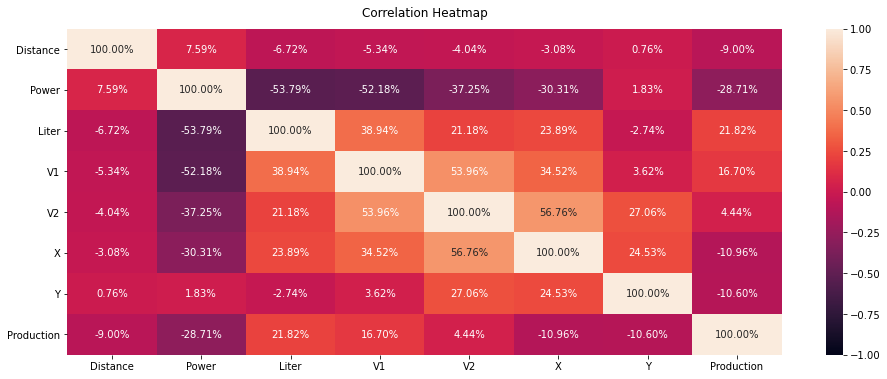

In [7]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2%')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


# Data preparation


In [8]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Using numpy to create arrays of lables and features
train_labels = np.array(train_df.pop('Production'))
test_labels = np.array(test_df.pop('Production'))
train_features = np.array(train_df)
test_features = np.array(test_df)

# Scaling the features using Standard Scaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (31672,)
Test labels shape: (7919,)
Training features shape: (31672, 7)
Test features shape: (7919, 7)


# Decision Tree


In [9]:
# Create a Decision Tree classifer object
clf_DT = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf_DT = clf_DT.fit(train_features,train_labels)

# Predict the response for test dataset
y_pred_DT = clf_DT.predict(test_features)

In [10]:
# Get the metrics for the Decision Tree
print(classification_report(test_labels,y_pred_DT))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5148
           1       0.94      0.93      0.94      2771

    accuracy                           0.96      7919
   macro avg       0.95      0.95      0.95      7919
weighted avg       0.96      0.96      0.96      7919



In [11]:
f1_DT = f1_score(test_labels, y_pred_DT, average='macro')
f1_DT

0.952678880881527

In [12]:
MCC_DT = matthews_corrcoef(test_labels, y_pred_DT)
MCC_DT

0.905400232891627

<function cf_matrix at 0x0000022DC0E33160>


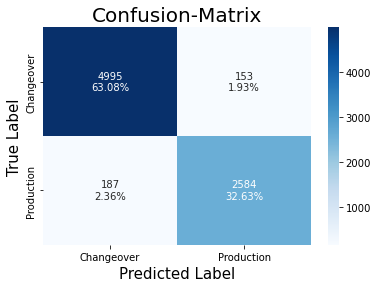

In [13]:
# Plot the confusion matrix for the Decision Tree
cf_matrix(test_labels,y_pred_DT)

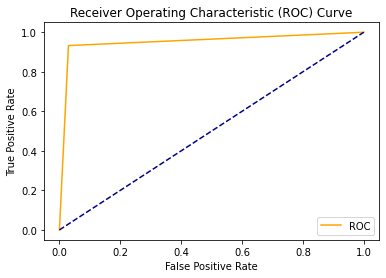

AUC score: 0.9513975288515166


In [14]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_DT)

# Neural Network


In [15]:
# Create neural network
clf_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100,activation='relu',input_shape=(7,)),
    tf.keras.layers.Dropout(0.1), #prevention of overfitting
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
    ])

# Set up and train neural network
opt = keras.optimizers.Adam(learning_rate=0.01)
clf_NN.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = clf_NN.fit(train_features,train_labels, epochs=50, batch_size=50,validation_data=(test_features, test_labels))
clf_NN.evaluate(test_features, test_labels)

# Predict the response for test dataset
y_pred_NN = clf_NN.predict(test_features,batch_size=1,verbose=0)

weights = clf_NN.get_weights() # returs a numpy list of weights

Epoch 1/50
634/634 [==============================] - 2s 2ms/step - loss: 0.4722 - accuracy: 0.7673 - val_loss: 0.4330 - val_accuracy: 0.7891
Epoch 2/50
634/634 [==============================] - 1s 2ms/step - loss: 0.4220 - accuracy: 0.7973 - val_loss: 0.4156 - val_accuracy: 0.7968
Epoch 3/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3964 - accuracy: 0.8112 - val_loss: 0.3905 - val_accuracy: 0.8139
Epoch 4/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3825 - accuracy: 0.8179 - val_loss: 0.3757 - val_accuracy: 0.8140
Epoch 5/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3691 - accuracy: 0.8271 - val_loss: 0.3471 - val_accuracy: 0.8480
Epoch 6/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3561 - accuracy: 0.8332 - val_loss: 0.3278 - val_accuracy: 0.8510
Epoch 7/50
634/634 [==============================] - 1s 2ms/step - loss: 0.3466 - accuracy: 0.8371 - val_loss: 0.3293 - val_accuracy: 0.8478
Epoch 

In [16]:
# Predicted values as integers
y_pred_NN = np.argmax(clf_NN.predict(test_features,batch_size=1,verbose=0), axis=-1)
print(y_pred_NN)

[0 1 0 ... 0 1 1]


In [17]:
# Get the metrics for the Neural Network
print(classification_report(test_labels,y_pred_NN))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5148
           1       0.87      0.76      0.81      2771

    accuracy                           0.88      7919
   macro avg       0.87      0.85      0.86      7919
weighted avg       0.88      0.88      0.87      7919



In [18]:
f1_NN = f1_score(test_labels, y_pred_NN, average='macro')
f1_NN

0.8592552332757791

In [19]:
MCC_NN = matthews_corrcoef(test_labels, y_pred_NN)
MCC_NN

0.7228618100139885

<function cf_matrix at 0x0000022DC0E33160>


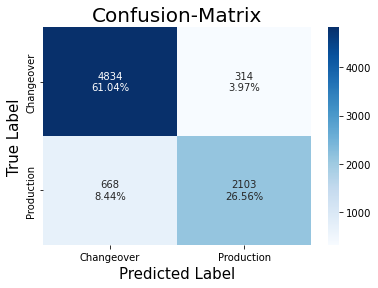

In [20]:
# Plot the confusion matrix for the Neural Network
cf_matrix(test_labels,y_pred_NN)

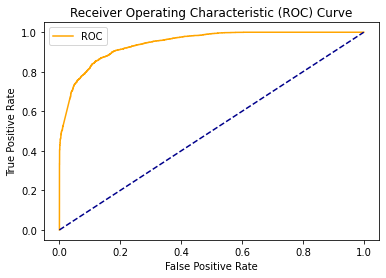

AUC score: 0.9444412197930783


In [21]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_NN)

# Balanced Random Forest


In [22]:
# Create a Balanced Random Forest classifer object
clf_BRF = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Train the Balanced Random Forest Classifer
clf_BRF = clf_BRF.fit(train_features,train_labels)

# Predict the response for test dataset
y_pred_BRF = clf_BRF.predict(test_features)

In [23]:
# Get the metrics for the Decision Tree
print(classification_report(test_labels,y_pred_BRF))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      5148
           1       0.95      0.96      0.96      2771

    accuracy                           0.97      7919
   macro avg       0.96      0.97      0.97      7919
weighted avg       0.97      0.97      0.97      7919



In [24]:
f1_BRF = f1_score(test_labels, y_pred_BRF, average='macro')
f1_BRF

0.9654635653916577

In [25]:
MCC_BRF = matthews_corrcoef(test_labels, y_pred_BRF)
MCC_BRF

0.9310423462283628

<function cf_matrix at 0x0000022DC0E33160>


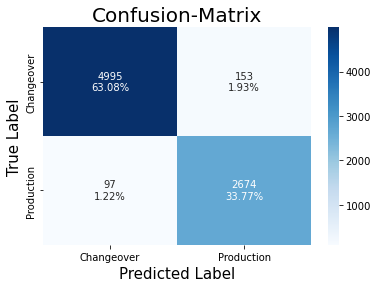

In [26]:
# Plot the confusion matrix for the Decision Tree
cf_matrix(test_labels,y_pred_BRF)

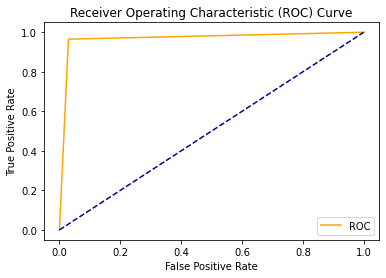

AUC score: 0.9676371535357462


In [27]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_BRF)

# Random Forest


In [28]:
# Create a Random Forest classifer object with best parameters found via grid search
clf_RF = RandomForestClassifier(n_estimators=48, bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=2, random_state=0)

# Train the Random Forest Classifer
clf_RF = clf_RF.fit(train_features, train_labels)

# Predict the response for test dataset
y_pred_RF = clf_RF.predict(test_features)

In [29]:
# Get the metrics for the Decision Tree
print(classification_report(test_labels,y_pred_RF))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5148
           1       0.97      0.95      0.96      2771

    accuracy                           0.98      7919
   macro avg       0.97      0.97      0.97      7919
weighted avg       0.98      0.98      0.98      7919



In [30]:
f1_RF = f1_score(test_labels, y_pred_RF, average='macro')
f1_RF

0.9725230691977741

In [31]:
MCC_RF = matthews_corrcoef(test_labels, y_pred_RF)
MCC_RF

0.9451775126239347

<function cf_matrix at 0x0000022DC0E33160>


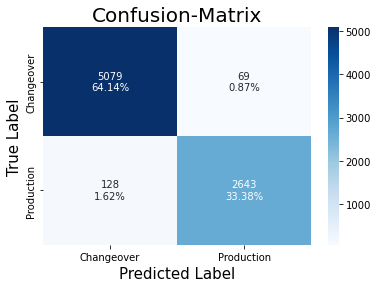

In [32]:
# Plot the confusion matrix for the Decision Tree
cf_matrix(test_labels,y_pred_RF)

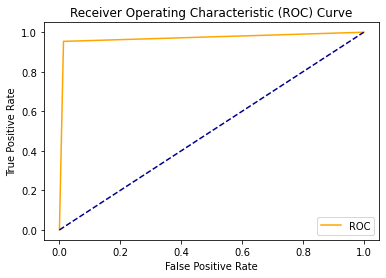

AUC score: 0.9702020131919086


In [33]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_RF)

# SVC


## ⚠️ <span style="color:red">**SVC takes a lot of time to run!!! More than 15 minutes!**</span> ⚠️

In [34]:
# Create a Random Forest classifer object with best parameters found via grid search
clf_SVC = SVC(kernel='rbf', C=100000)

# Train the Random Forest Classifer
clf_SVC = clf_SVC.fit(train_features, train_labels)

# Predict the response for test dataset
y_pred_SVC = clf_SVC.predict(test_features)

In [35]:
# Get the metrics for the Decision Tree
print(classification_report(test_labels,y_pred_SVC))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5148
           1       0.91      0.73      0.81      2771

    accuracy                           0.88      7919
   macro avg       0.89      0.84      0.86      7919
weighted avg       0.88      0.88      0.88      7919



In [36]:
f1_SVC = f1_score(test_labels, y_pred_SVC, average='macro')
f1_SVC

0.8602850449576763

In [40]:
f1_SVC_static = 0.8602850449576763

In [37]:
MCC_SVC = matthews_corrcoef(test_labels, y_pred_SVC)
MCC_SVC

0.7308375730727619

In [41]:
MCC_SVC_static = 0.7308375730727619

<function cf_matrix at 0x0000022DC0E33160>


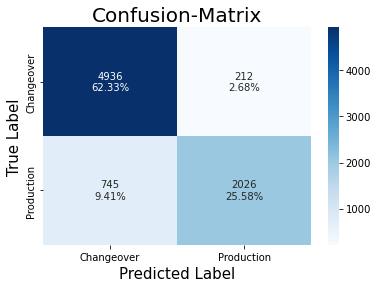

In [38]:
# Plot the confusion matrix for the Decision Tree
cf_matrix(test_labels,y_pred_SVC)

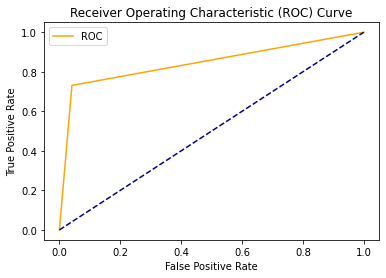

AUC score: 0.8449814750789129


In [39]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_SVC)

In [42]:
AUC_SVC_static = 0.8449814750789129

# Comparison tables


In [43]:
comp_table = pd.DataFrame(index=['Neural Network', 'SVC', 'Decision Tree', 'Balanced Random Forest', 'Random Forest'], columns=['F1 score', 'AUC score', 'MCC'])

In [44]:
comp_table.iloc[0] = [f1_NN, roc_auc_score(test_labels, y_pred_NN), MCC_NN]
comp_table.iloc[1] = [f1_SVC_static, AUC_SVC_static, MCC_SVC_static]
comp_table.iloc[2] = [f1_DT, roc_auc_score(test_labels, y_pred_DT), MCC_DT]
comp_table.iloc[3] = [f1_BRF, roc_auc_score(test_labels, y_pred_BRF), MCC_BRF]
comp_table.iloc[4] = [f1_RF, roc_auc_score(test_labels, y_pred_RF), MCC_RF]

In [45]:
for i in range(len(comp_table)):
    comp_table.iloc[i] = comp_table.iloc[i].apply(lambda x: round(x, 2))

In [46]:
comp_table


,F1 score,AUC score,MCC
Neural Network,0.86,0.85,0.72
SVC,0.86,0.84,0.73
Decision Tree,0.95,0.95,0.91
Balanced Random Forest,0.97,0.97,0.93
Random Forest,0.97,0.97,0.95


<ipython-input-47-ecdbc516de2a>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,i].xaxis.set_ticklabels(['Changeover', 'Production'])
<ipython-input-47-ecdbc516de2a>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,i].yaxis.set_ticklabels(['Changeover', 'Production'], va='center')


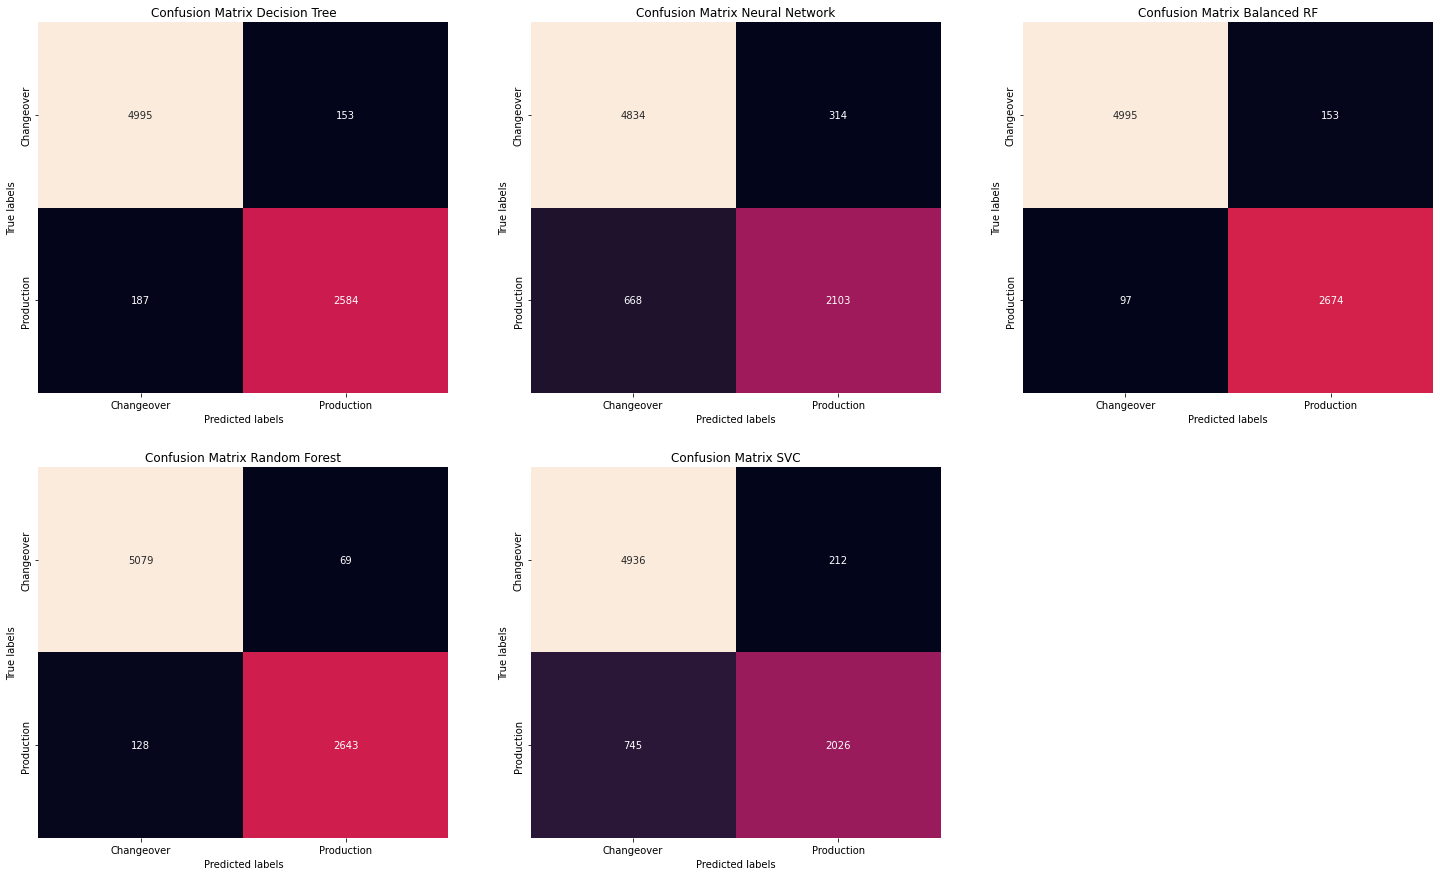

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))

labels = ['Changeover', 'Production']

sns.heatmap(confusion_matrix(test_labels, y_pred_DT), cbar=False, annot=True, fmt='g', ax=axs[0,0])
axs[0,0].set_title('Confusion Matrix Decision Tree')

sns.heatmap(confusion_matrix(test_labels, y_pred_NN), cbar=False, annot=True, fmt='g', ax=axs[0,1])
axs[0,1].set_title('Confusion Matrix Neural Network')

sns.heatmap(confusion_matrix(test_labels, y_pred_BRF), cbar=False, annot=True, fmt='g', ax=axs[0,2])
axs[0,2].set_title('Confusion Matrix Balanced RF')

sns.heatmap(confusion_matrix(test_labels, y_pred_RF), cbar=False, annot=True, fmt='g', ax=axs[1,0])
axs[1,0].set_title('Confusion Matrix Random Forest')


sns.heatmap(confusion_matrix(test_labels, y_pred_SVC), cbar=False, annot=True, fmt='g', ax=axs[1,1])
axs[1,1].set_title('Confusion Matrix SVC')

for i in range(0,3): #iterating through our graphs to give a label to each
    axs[0,i].set(xlabel='Predicted labels')
    axs[0,i].set(ylabel='True labels')
    axs[0,i].xaxis.set_ticklabels(['Changeover', 'Production'])
    axs[0,i].yaxis.set_ticklabels(['Changeover', 'Production'], va='center')
    axs[1,i].set(xlabel='Predicted labels')
    axs[1,i].set(ylabel='True labels')
    axs[1,i].xaxis.set_ticklabels(['Changeover', 'Production'])
    axs[1,i].yaxis.set_ticklabels(['Changeover', 'Production'], va='center')

fig.delaxes(axs[1,2])